<h1>Enhanced CNN-LSTM Model For Real Life IDS as Edge Device</h1>

In [28]:
!pip install scikeras
import shutil
import os
import glob
import polars as pl
import numpy as np
import gc
import time
import tensorflow.lite as tflite
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Normalization
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.optimizers import Adam

## 

<h2>CNN-LSTM Configuration</h2>

In [2]:
BATCH_SIZE = 128   
EPOCHS = 20        
N_FEATURES = 38
NUM_CLASSES = 2 

<h2>About Data</h2>

In [30]:
import glob
import polars as pl
import numpy as np

CSV_PATTERN = '/kaggle/input/0-5-8classes-ciciot-2023/*.csv'
LABEL_COL = "label" 

files = sorted(glob.glob(CSV_PATTERN))
if not files:
    print("ERROR: No files found! Check path.")
else:
    first_file = files[0]
    print(f"Inspecting file: {first_file}")

    try:
        df = pl.read_csv(first_file, n_rows=100, ignore_errors=True)
        
        print(f"\n--- Columns Found ({len(df.columns)}) ---")
        print(df.columns)
        
        if LABEL_COL in df.columns:
            print(f"\n--- Unique Labels in first 100 rows ---")
            print(df[LABEL_COL].unique().to_list())
            
            n_features_actual = len(df.columns) - 1
            print(f"\n--- ACTUAL N_FEATURES ---")
            print(f"Your CSV has {n_features_actual} features.")
            print(f"You set N_FEATURES = 40. Do they match? {n_features_actual == 40}")
        else:
            print(f"\nCRITICAL ERROR: Column '{LABEL_COL}' not found in CSV!")
            print(f"Did you mean one of these? {df.columns}")

    except Exception as e:
        print(f"Error reading file: {e}")

Inspecting file: /kaggle/input/0-5-8classes-ciciot-2023/0.5percent_8classes.csv

--- Columns Found (47) ---
['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'radius', 'covariance', 'variance', 'weight', 'label', 'magnitude']

--- Unique Labels in first 100 rows ---
['DDoS', 'Benign', 'Mirai', 'DoS', 'Spoofing']

--- ACTUAL N_FEATURES ---
Your CSV has 46 features.
You set N_FEATURES = 40. Do they match? False


In [4]:
import numpy as np
import pandas as pd 
import polars as pl

iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}
reversed_dict = {value: key for key, value in iana_map.items()}

dtypes = {'ece_flag_number': pl.Float32,
 'http': pl.Float32,
 'fin_flag_number': pl.Float32,
 'psh_flag_number': pl.Float32,
 'syn_count': pl.Float32,
 'dhcp': pl.Float32,
 'smtp': pl.Float32,
 'ipv': pl.Float32,
 'tot_sum': pl.Float32,
 'number': pl.Float32,
 'dns': pl.Float32,
 'std': pl.Float32,
 'telnet': pl.Float32,
 'iat': pl.Float32,
 'udp': pl.Float32,
 'fin_count': pl.Float32,
 'rst_flag_number': pl.Float32,
 'min': pl.Float32,
 'variance': pl.Float32,
 'duration': pl.Float32,
 # 'time_to_live':pl.Float32,
 'rate': pl.Float32,
 'ack_flag_number': pl.Float32,
 'syn_flag_number': pl.Float32,
 'cwr_flag_number': pl.Float32,
 'tcp': pl.Float32,
 'icmp': pl.Float32,
  # 'igmp':pl.Float32,
 'ack_count': pl.Float32,
 'https': pl.Float32,
 # 'flow_duration': pl.Float32,
 'rst_count': pl.Float32,
 'max': pl.Float32,
 'ssh': pl.Float32,
 'irc': pl.Float32,
 'avg': pl.Float32,
 'header_length': pl.Float32,
 'protocol_type': pl.Float32,
 'llc': pl.Float32,
 'arp': pl.Float32,
 'tot_size': pl.Float32,
 'label': str,
         }

def convert_dtype(df):
    # Adjust data type
    for col,typ in dtypes.items():
        df = df.with_columns(pl.col(col).cast(typ)) 
    
   
    return df
lis=['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']

lis=list(map(str.lower,lis))

mapping={'True':1,'False':0}

def iana_convert(df):
    df= df.with_columns(
        pl.col(lis).replace_strict(mapping,return_dtype=pl.Int64))
    
    df = df.with_columns(
    pl.col("protocol_type").replace_strict(reversed_dict).alias("protocol_type")
)
    return df

In [5]:
common=['ack_count',
 'ack_flag_number',
 'arp',
 'avg',
 'cwr_flag_number',
 'dhcp',
 'dns',
 'duration',
 'ece_flag_number',
 'fin_count',
 'fin_flag_number',
 'header_length',
 'http',
 'https',
 'iat',
 'icmp',
 'ipv',
 'irc',
 'llc',
 'max',
 'min',
 'number',
 'protocol_type',
 'psh_flag_number',
 'rate',
 'rst_count',
 'rst_flag_number',
 'smtp',
 'ssh',
 'std',
 'syn_count',
 'syn_flag_number',
 'tcp',
 'telnet',
 'tot_size',
 'tot_sum',
 'udp',
 'variance',
 'label'
       ]
len(common)

39

In [6]:
#Top 25 of Random forest
top_25={'iat',
'flow_duration',
'header_length',
'rst_count',
'urg_count',
'rate',
'srate',
'tot_size',
'syn_count',
'avg',
'magnitude',
'duration',
'protocol_type',
'max',
'tot_sum',
'covariance',
'https',
'radius',NUM_CLASSES
'min',
'std',
'variance',
'weight',
'number',
'ack_count',
'udp','label'}

### Using Top 19 from random forest top 25 and from the paper implement 39 features

In [7]:
diff=['ack_count',
 'avg',
 'duration',
 'header_length',
 'https',
 'iat',
  'max',
 'min',
 'number',
 'protocol_type',
 'rate',
 'rst_count',
 'std',
 'syn_count',
 'tot_size',
 'tot_sum',
 'udp',
 'variance',
     'label']

In [8]:
# Mapping them to Integers for the AI model
CLASS_TO_INT = {
    'DDoS': 1,
    'Mirai': 1,
    'Recon': 1,
    'Spoofing': 1,
    'DoS':1,
    'Benign': 0,
    'Web':1,
    'BruteForce':1
}
TARGET_CLASSES = ['Spoofing', 'Recon', 'Benign', 'Mirai', 'DDoS']


In [9]:

if os.path.exists("processed_data"):
    shutil.rmtree("processed_data")
    print("Cleaned up old processed data.")
else:
    print("No existing data found.")

os.makedirs("processed_data", exist_ok=True)





INPUT_CSV = "/kaggle/input/0-5-8classes-ciciot-2023/0.5percent_8classes.csv" 
OUTPUT_DIR = "processed_data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# lazy Pipeline
lf = pl.scan_csv(INPUT_CSV, infer_schema=False)

lf = iana_convert(lf)
lf = convert_dtype(lf)
lf = lf.select(common)
lf = lf.filter(pl.col('label').is_in(TARGET_CLASSES))
lf = lf.with_columns(pl.col('label').replace(CLASS_TO_INT).cast(pl.Int32))

print("Processing data in streaming mode...")
df = lf.collect(engine='streaming')


print(df['label'].value_counts())

attack = df.filter(pl.col('label') != 0)
if attack.height > 0:
    attack = pl.concat([
        group.sample(n=min(56528, group.height), seed=42) 
        for group in attack.partition_by("label")
    ])
normal = df.filter(pl.col('label') == 0)
df = pl.concat([attack, normal]).sample(fraction=1.0, shuffle=True, seed=42)
df=df.select(common)
print(df.columns)


gc.collect()

# 4. Calculate Split points
total_rows = df.height
rows_per_file = int(np.ceil(total_rows / 7))
print(f"Total processed rows: {total_rows}. Saving {rows_per_file} per file.")
print(df['label'].value_counts())

for i in range(7):
    start = i * rows_per_file
    
    chunk = df.slice(start, rows_per_file)
    
    if chunk.height > 0:
        output_path = os.path.join(OUTPUT_DIR, f"part_{i+1}.parquet")
        chunk.write_parquet(output_path, compression="snappy")
        print(f"Saved: {output_path} ({chunk.height} rows)")
    
    del chunk
    gc.collect() 

del df
gc.collect()
print("All 7 parts saved successfully.")


Cleaned up old processed data.
Processing data in streaming mode...
shape: (2, 2)
┌───────┬──────────┐
│ label ┆ count    │
│ ---   ┆ ---      │
│ i32   ┆ u32      │
╞═══════╪══════════╡
│ 0     ┆ 549102   │
│ 1     ┆ 18729836 │
└───────┴──────────┘
['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance', 'label']
Total processed rows: 605630. Saving 86519 per file.
shape: (2, 2)
┌───────┬────────┐
│ label ┆ count  │
│ ---   ┆ ---    │
│ i32   ┆ u32    │
╞═══════╪════════╡
│ 1     ┆ 56528  │
│ 0     ┆ 549102 │
└───────┴────────┘
Saved: processed_data/part_1.parquet (86519 rows)
Saved: processed_data/part_2.parquet (86519 r

<h1>Batch Processing</h1>

<h1>CNN-LSTM Without Universal Mean and Variance </h1>

In [10]:
y_sample = []
files = sorted(glob.glob("/kaggle/working/processed_data/*.parquet"))

for f in files[:10]: 
    df = pl.read_parquet(files)
    y_sample.extend(df["label"].to_numpy())

classes = np.unique(y_sample)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_sample)
class_weights_dict = dict(zip(classes, weights))

del df

In [11]:



def fast_parquet_generator(file_paths, batch_size, n_features, n_classes):
    for file_path in file_paths:
        try:
            df = pl.read_parquet(file_path)
            if df.height == 0: continue

            data = df.to_numpy()
            
            # Replace Infinity and NaN with 0.0 to prevent model crash
            data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

            X = data[:,:-1]
            y = data[:, -1]
            del data
            num_rows = X.shape[0]
            for start_idx in range(0, num_rows, batch_size):
                end_idx = min(start_idx + batch_size, num_rows)
                
                batch_X = X[start_idx:end_idx]
                batch_y = y[start_idx:end_idx]
                
                # Reshape
                batch_X = batch_X.reshape(-1, n_features, 1)
                
                # One-hot
                batch_y_one_hot = np.eye(n_classes)[batch_y.astype(int)]
                
                yield (batch_X, batch_y_one_hot)
            del X
            del y
            del batch_X
            del batch_y
        except Exception as e:
            print(f"Skipping bad file: {e}")
            continue




In [12]:


def build_proposed_model(input_shape, num_classes):
    model = Sequential([
        Normalization(axis=-1, name="scaler"), 

        Conv1D(filters=32, kernel_size=9, activation='relu', padding='same'),

        MaxPooling1D(pool_size=2),

        LSTM(16, return_sequences=False, dropout=0.2,unroll=True),

        Dense(num_classes, activation="sigmoid") 
    ])

    model.compile(
        optimizer=Adam(), 
        # loss="binary_crossentropy", 
        loss="binary_crossentropy", 
        
        metrics=["accuracy", tf.keras.metrics.Recall(name="recall")]
    )
    
    return model


  


In [13]:

def proposed_pipeline(parquet_pattern):
    all_files = sorted(glob.glob(parquet_pattern))
    total_files = len(all_files)
    
    if total_files == 0:
        raise ValueError("No Parquet files found! Check your path.")

    train_end = int(total_files * 0.8)
    val_end = int(total_files * 0.9)
    
    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]
    
    print(f"Split: {len(train_files)} Train | {len(val_files)} Val | {len(test_files)} Test")

    output_signature = (
        tf.TensorSpec(shape=(None, N_FEATURES, 1), dtype=tf.float64),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float64)
    )

    train_ds = tf.data.Dataset.from_generator(
        lambda: fast_parquet_generator(train_files, BATCH_SIZE, N_FEATURES, NUM_CLASSES),
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_generator(
        lambda: fast_parquet_generator(val_files, BATCH_SIZE, N_FEATURES, NUM_CLASSES),
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_generator(
        lambda: fast_parquet_generator(test_files, BATCH_SIZE, N_FEATURES, NUM_CLASSES),
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

    print("Calibrating Z-Score Normalization...")
    
    # We define the input shape explicitly so weights are created immediately
    model = build_proposed_model((N_FEATURES, 1), NUM_CLASSES)
    model.build((None, N_FEATURES, 1)) 

    for sample_X, _ in train_ds.take(1):
        sample_X_numpy = sample_X.numpy()
        model.get_layer("scaler").adapt(sample_X_numpy)
        print(f"  Normalization adapted on batch shape: {sample_X_numpy.shape}")

    print("Starting Training (20 Epochs)...")
    
    # Calculate steps (approximate)
    # 2000 is a good safety limit to see updates frequently
    STEPS_PER_EPOCH = 2000
    
    history = model.fit(
        train_ds.repeat(),
        validation_data=val_ds.repeat(),
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH, 
        validation_steps=100,
        verbose=1,
        class_weight=class_weights_dict, 
        
    )
        
    # --- 5. DETAILED EVALUATION ---
    print("\n6. Running Final Evaluation on Test Set (10%)...")
    
    # A. Standard Metrics (Loss/Accuracy)
    acc = model.evaluate(test_ds, steps=200)
    # print(f"   Test Accuracy: {acc*100:.2f}%")
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    print("\n--- Calculating IDS Reliability Metrics ---")
    
    # --- 5. DETAILED EVALUATION ---
    print("\n6. Running Final Evaluation on Test Set...")

    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
    import seaborn as sns

    y_true = []
    y_pred = []
    y_prob = []

    # Using 300 batches to ensure a statistically significant sample
    for X_batch, y_batch in test_ds.take(300):
        # 1. Store True Labels (One-Hot -> Class Index)
        true_labels = np.argmax(y_batch.numpy(), axis=1)
        y_true.extend(true_labels)
        
        # 2. Get Model Predictions (Probabilities and Hard Classes)
        probs = model.predict(X_batch, verbose=0)
        y_prob.extend(probs[:, 1]) # Probability of Attack class
        y_pred.extend(np.argmax(probs, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # ---------- CONFUSION MATRIX VISUALIZATION ----------
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Attack (1)'], 
                yticklabels=['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix – CNN-LSTM Edge IDS')
    plt.show()

    # Extract standard metrics from CM
    tn, fp, fn, tp = cm.ravel()
    fpr = (fp / (fp + tn)) * 100 if (fp + tn) > 0 else 0
    
    print("\n" + "="*40)
    print("IDS PERFORMANCE SUMMARY")
    print("="*40)
    print(f"True Positives (TP) : {tp}  (Attacks correctly blocked)")
    print(f"True Negatives (TN) : {tn}  (Normal traffic allowed)")
    print(f"False Positives (FP): {fp}  (Normal traffic wrongly flagged)")
    print(f"False Negatives (FN): {fn}  (Attacks wrongly allowed)")
    print(f"False Positive Rate (FPR): {fpr:.4f}%")
    print("="*40)

    # ---------- CLASSIFICATION REPORT ----------
    print("\nCLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, target_names=["Normal (0)", "Attack (1)"]))

    # ---------- ROC & PR CURVES ----------
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr_vals, tpr_vals)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(12, 5))
    
    # Subplot: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_vals, tpr_vals, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Subplot: PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AP = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    print(f"Final ROC–AUC: {roc_auc:.4f}")
    print(f"Final PR–AUC : {pr_auc:.4f}")

    return model




<h2>Model Execution</h2>

Split: 5 Train | 1 Val | 1 Test
Calibrating Z-Score Normalization...


2026-01-07 05:52:16.565702: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Normalization adapted on batch shape: (128, 38, 1)
Starting Training (20 Epochs)...
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.9561 - loss: 0.1668 - recall: 0.9405 - val_accuracy: 0.9980 - val_loss: 0.0226 - val_recall: 0.9980
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9978 - loss: 0.0554 - recall: 0.9978 - val_accuracy: 0.9980 - val_loss: 0.0271 - val_recall: 0.9980
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9975 - loss: 0.0516 - recall: 0.9976 - val_accuracy: 0.9980 - val_loss: 0.0234 - val_recall: 0.9980
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9979 - loss: 0.0535 - recall: 0.9979 - val_accuracy: 0.9980 - val_loss: 0.0262 - val_recall: 0.9980
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9978 - loss: 0.0530 - recall: 0.9978 - val_accuracy: 0.9980 - val_loss: 0.0316 - val_recall: 0.9980
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accura

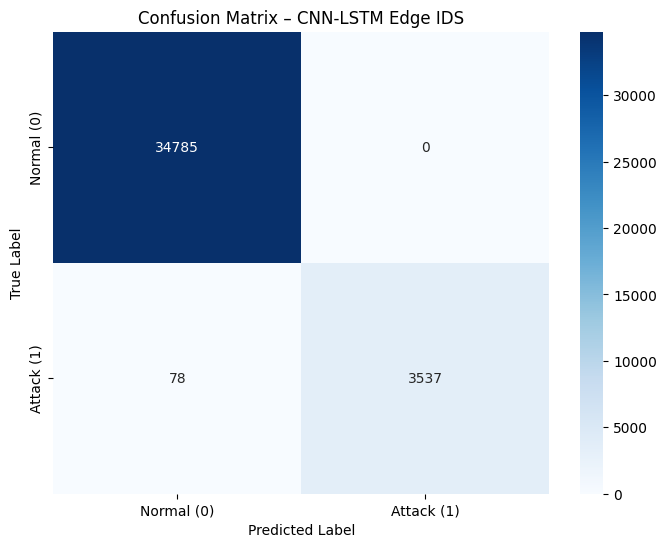


IDS PERFORMANCE SUMMARY
True Positives (TP) : 3537  (Attacks correctly blocked)
True Negatives (TN) : 34785  (Normal traffic allowed)
False Positives (FP): 0  (Normal traffic wrongly flagged)
False Negatives (FN): 78  (Attacks wrongly allowed)
False Positive Rate (FPR): 0.0000%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     34785
  Attack (1)       1.00      0.98      0.99      3615

    accuracy                           1.00     38400
   macro avg       1.00      0.99      0.99     38400
weighted avg       1.00      1.00      1.00     38400



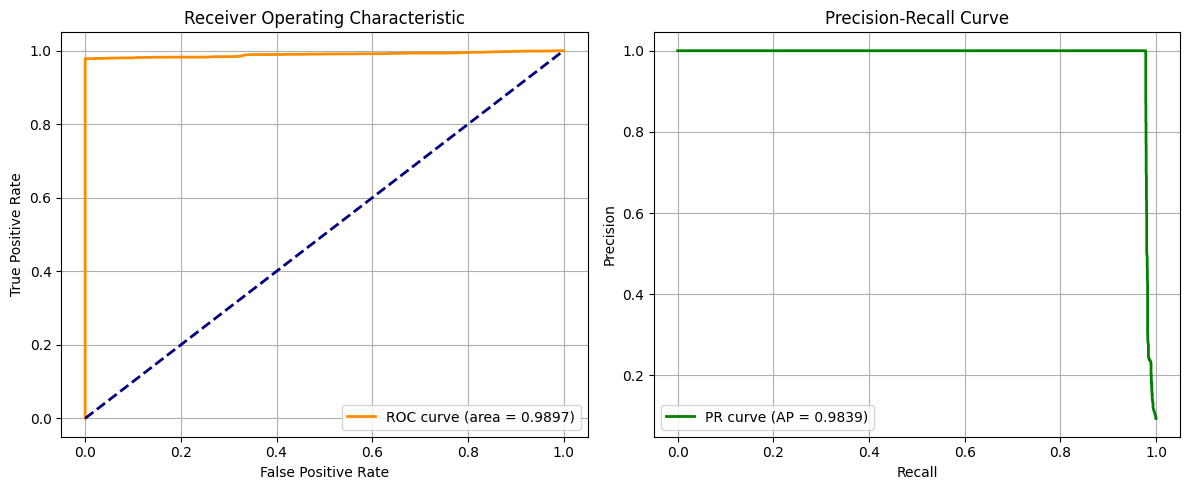

Final ROC–AUC: 0.9897
Final PR–AUC : 0.9839


In [14]:
model = proposed_pipeline("processed_data/*.parquet")


<h2>in Class wise labeled data files, distribution of classes</h2>
<br>

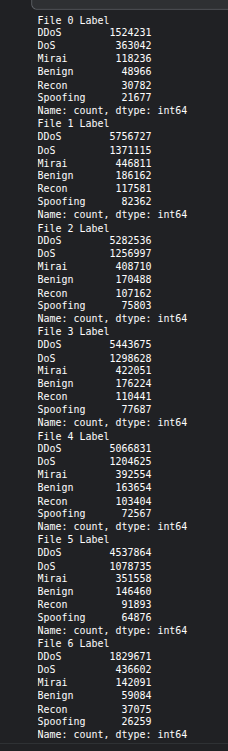
<br>


<h2>Saving Model</h2>

In [15]:
MODEL_SAVE_PATH = "saved_models/fog_ods_model_final.tflite"

print("Exporting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

os.makedirs("saved_models", exist_ok=True)
with open(MODEL_SAVE_PATH, "wb") as f:
    f.write(tflite_model)
    
print(f"✅ Saved to {MODEL_SAVE_PATH}")

Exporting to TFLite...
INFO:tensorflow:Assets written to: /tmp/tmpi01lod6_/assets


INFO:tensorflow:Assets written to: /tmp/tmpi01lod6_/assets


Saved artifact at '/tmp/tmpi01lod6_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 38, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134339032760592: TensorSpec(shape=(1, 1, 1), dtype=tf.float32, name=None)
  134339032760400: TensorSpec(shape=(1, 1, 1), dtype=tf.float32, name=None)
  134351360635152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360635728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360633040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360637456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351370845840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360636880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360636688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134351360636304: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1767765569.607678      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767765569.607878      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1767765569.628738      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


✅ Saved to saved_models/fog_ods_model_final.tflite


<h1>CNN-LSTM With Universal Mean and Variance </h1>

In [16]:
import polars as pl
import glob
import json
import numpy as np
import gc

# --- CONFIG ---
DATA_PATTERN = "/kaggle/working/processed_data/*.parquet" 
OUTPUT_JSON = "scaler_params_new.json"

print("1. Initializing Streaming Calculation...")
files = glob.glob(DATA_PATTERN)
if not files: raise ValueError("No files found!")

total_count = 0
sum_x = np.zeros(N_FEATURES, dtype=np.float64)
sum_sq_x = np.zeros(N_FEATURES, dtype=np.float64)

for i, f in enumerate(files):
    try:
        df = pl.read_parquet(f)
        print(df.columns)
        
        if "label" in df.columns:
            df = df.drop("label")
        else:
            df = df[:, :-1]
            
        df = df.cast(pl.Float64)
        
        chunk_data = df.to_numpy()
        
        chunk_data = np.nan_to_num(chunk_data, nan=0.0, posinf=0.0, neginf=0.0)
        
        # --- UPDATE RUNNING STATS ---
        n = chunk_data.shape[0]
        total_count += n
        
        # 2. Sum of X (for Mean)
        # axis=0 collapses rows, gives sum per column
        sum_x += np.sum(chunk_data, axis=0) 
        
        # 3. Sum of X^2 (for Variance)
        # We square every number first, then sum
        sum_sq_x += np.sum(chunk_data**2, axis=0)
        
        # Clean up memory immediately
        del df, chunk_data
        gc.collect()
        print(f"   Processed {i+1}/{len(files)} files... (Rows so far: {total_count})")
            
    except Exception as e:
        print(f"   Skipping corrupt file {f}: {e}")

print("\n3. Calculating Final Global Stats...")

# Global Mean = Sum(x) / N
global_mean = sum_x / total_count

# Global Variance = (Sum(x^2) / N) - (Mean^2)
global_var = (sum_sq_x / total_count) - (global_mean ** 2)

scaler_stats = {
    "mean": global_mean.tolist(),
    "variance": global_var.tolist()
}

with open(OUTPUT_JSON, "w") as f:
    json.dump(scaler_stats, f)

print("\n✅ SUCCESS!")
print(f"   Processed Total Rows: {total_count}")
print(f"   Saved to {OUTPUT_JSON}")
print(f"   Mean Vector Size: {len(scaler_stats['mean'])} (Target: 39)")

1. Initializing Streaming Calculation...
['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance', 'label']
   Processed 1/7 files... (Rows so far: 86519)
['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance', 'label']
   Processed 2/7 files... (Rows so far: 

In [17]:
import tensorflow as tf
import polars as pl
import numpy as np
import glob
import json
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape


SCALER_PATH = "/kaggle/working/scaler_params_new.json"         
DATA_PATTERN = "/kaggle/working/processed_data/*.parquet"
MODEL_SAVE_PATH = "saved_models/fog_ods_model_final.tflite"

#  Load Scaler & Calculate Weights ---
print("1. Loading Scaler Stats...")
with open(SCALER_PATH, "r") as f:
    stats = json.load(f)
    mean_val = np.array(stats["mean"], dtype=np.float32).reshape(-1)
    var_val = np.array(stats["variance"], dtype=np.float32).reshape(-1)

print("2. Calculating Class Weights (to fix bias)...")
files = sorted(glob.glob(DATA_PATTERN))
if not files: raise ValueError("No files found!")

# Peek at first 10 files to estimate weights
y_sample = []
for f in files[:10]: 
    df = pl.read_parquet(f)
    y_sample.extend(df["label"].to_numpy())

classes = np.unique(y_sample)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_sample)
class_weights_dict = dict(zip(classes, weights))
print(f"   Weights: {class_weights_dict}")

# --- 2. DATA PIPELINE (80/10/10 Split) ---
total_files = len(files)
train_end = int(total_files * 0.8)
val_end = int(total_files * 0.9)

train_files = files[:train_end]
val_files = files[train_end:val_end]
test_files = files[val_end:]

print(f"3. Split: {len(train_files)} Train | {len(val_files)} Val | {len(test_files)} Test")

def fast_parquet_generator(file_paths):
    for file_path in file_paths:
        try:
            df = pl.read_parquet(file_path)
            # Force Float64 to avoid schema errors
            df = df.cast(pl.Float64) 
            data = np.nan_to_num(df.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)
            
            X = data[:, :-1]
            y = data[:,-1]
            
            # Batching
            num_rows = X.shape[0]
            for start_idx in range(0, num_rows, BATCH_SIZE):
                end_idx = min(start_idx + BATCH_SIZE, num_rows)
                batch_X = X[start_idx:end_idx]
                batch_y = y[start_idx:end_idx]
                
                # Reshape (Batch, Features, 1)
                batch_X = batch_X.reshape(-1, N_FEATURES, 1)
                
                # One-Hot Encoding
                batch_y_one_hot = np.eye(NUM_CLASSES)[batch_y.astype(int)]
                
                yield (batch_X, batch_y_one_hot)
        except Exception:
            continue

# Create TF Datasets
output_sig = (
    tf.TensorSpec(shape=(None, N_FEATURES, 1), dtype=tf.float64),
    tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float64)
)

train_ds = tf.data.Dataset.from_generator(lambda: fast_parquet_generator(train_files), output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_generator(lambda: fast_parquet_generator(val_files), output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
# For testing, we don't shuffle/repeat so we can compare predictions 1-to-1
test_ds = tf.data.Dataset.from_generator(lambda: fast_parquet_generator(test_files), output_signature=output_sig)

# --- 3. MODEL BUILDING ---
print("4. Building Model...")
mean_tensor = tf.constant(mean_val.reshape(1, N_FEATURES, 1), dtype=tf.float32)
scale_tensor = tf.constant(np.sqrt(var_val).reshape(1, N_FEATURES, 1), dtype=tf.float32)

def build_proposed_model(input_shape, num_classes):
    # Define Input explicitly
    inputs = tf.keras.Input(shape=input_shape) # Shape: (39, 1)

    # --- Manual Normalization ---
    # Formula: (x - mean) / (std_dev + epsilon)
    # We add 1e-7 to avoid dividing by zero if variance is 0
    x = (inputs - mean_tensor) / (scale_tensor + 1e-7)

    x = Conv1D(filters=32, kernel_size=9, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    # unroll=True is critical for TFLite on Raspberry Pi
    x = LSTM(16, return_sequences=False, dropout=0.2, unroll=True)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

print("4. Building Model (Functional API)...")
model = build_proposed_model((N_FEATURES, 1), NUM_CLASSES)

print("5. Starting Training...")
history = model.fit(
    train_ds.repeat(),
    validation_data=val_ds.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=2000,
    validation_steps=100,
    class_weight=class_weights_dict, 
    verbose=1
)
print("\n6. Running Final Evaluation on Test Set (10%)...")

loss, acc = model.evaluate(test_ds, steps=200)
print(f"   Test Accuracy: {acc*100:.2f}%")

print("   Generating detailed Classification Report (Wait for it)...")
y_true = []
y_pred = []

for X_batch, y_batch in test_ds.take(200): 
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    
    # Get Predictions
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

print("\n" + "="*40)
print("CLASSIFICATION REPORT")
print("="*40)
if(NUM_CLASSES==2):
    print(classification_report(y_true, y_pred, target_names=["Normal (0)", "Attack (1)"]))
    print("="*40)
else:
    print(classification_report(y_true, y_pred))
    print("="*40)

MODEL_SAVE_PATH = "saved_models/With_universal_mean_variance.tflite"

print("7. Exporting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

os.makedirs("saved_models", exist_ok=True)
with open(MODEL_SAVE_PATH, "wb") as f:
    f.write(tflite_model)
    
print(f"✅ Saved to {MODEL_SAVE_PATH}")

1. Loading Scaler Stats...
2. Calculating Class Weights (to fix bias)...
   Weights: {np.int32(0): np.float64(0.5514731324963303), np.int32(1): np.float64(5.356902773846589)}
3. Split: 5 Train | 1 Val | 1 Test
4. Building Model...
4. Building Model (Functional API)...
5. Starting Training...
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.8659 - loss: 0.2041 - val_accuracy: 0.9948 - val_loss: 0.0285
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9931 - loss: 0.0635 - val_accuracy: 0.9962 - val_loss: 0.0320
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9946 - loss: 0.0529 - val_accuracy: 0.9983 - val_loss: 0.0192
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9961 - loss: 0.0531 - val_accuracy: 0.9964 - val_loss: 0.0287
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9963 - loss: 0.0484 - val_accuracy: 0.9926 - val_loss: 0.0420
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10

INFO:tensorflow:Assets written to: /tmp/tmpar4tcqw4/assets


Saved artifact at '/tmp/tmpar4tcqw4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 38, 1), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134351360625360: TensorSpec(shape=(1, 38, 1), dtype=tf.float32, name=None)
  134338862931920: TensorSpec(shape=(1, 38, 1), dtype=tf.float32, name=None)
  134338862938448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862938640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862939024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862936720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862938064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862932688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134338862935184: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1767766002.873485      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767766002.873542      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ Saved to saved_models/With_universal_mean_variance.tflite


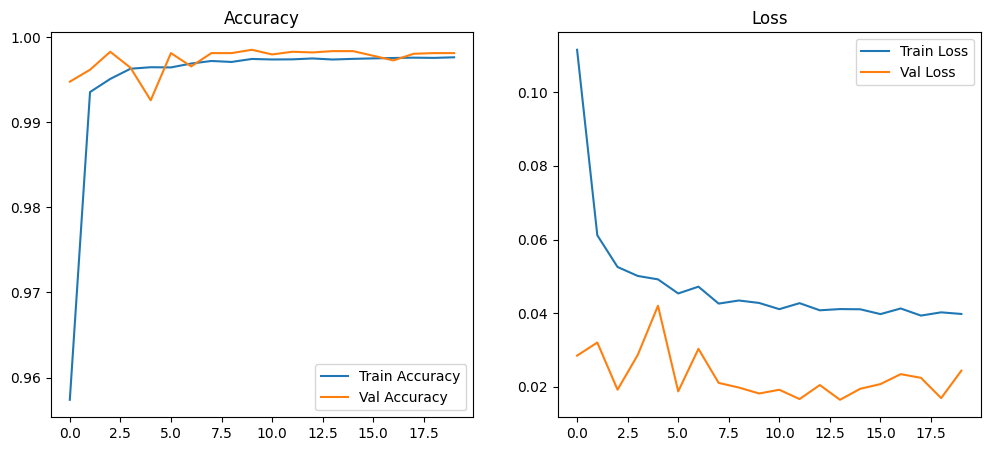

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [19]:
import polars as pl
import glob
import numpy as np
import random
import json
import pandas as pd

leb=['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance', 'label']
DATA_DIR = "processed_data/*.parquet" 

files = glob.glob(DATA_DIR)
if not files: raise ValueError("No data files found!")
random_file = random.choice(files)

print(f"Reading from: {random_file}")
df = pl.read_parquet(random_file)

attack=df.filter(pl.col('label') == 1)
beign=df.filter(pl.col('label') == 0)
attack=attack.sample(n=5)
beign=beign.sample(n=1000)
sample_row = pl.concat([attack,beign])
sample_row=sample_row.sample(fraction=1.0,shuffle=True,seed=42)
label=sample_row['label']
label=label.to_numpy()
sample_row=sample_row.drop('label')
data_numpy = sample_row.to_numpy() 
real_features = data_numpy

# Handle NaNs just like training
real_features = np.nan_to_num(real_features, nan=0.0, posinf=0.0, neginf=0.0)

data=(real_features.tolist())


file="Random_attacks2.json"
true_label="true_attacks.json"
try:
    with open(file,"w") as json_file:
        json.dump(data,json_file,indent=4)
    print("Random attacks")
except:
    print("Error")


print(label)

Reading from: processed_data/part_1.parquet
Random attacks
[0 0 0 ... 0 0 0]


In [20]:
l=['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance', 'label']

<h1>Creating testing files</h1>

In [21]:
import numpy as np
import pandas as pd 
import polars as pl

iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}
reversed_dict = {value: key for key, value in iana_map.items()}

dtypes = {'ece_flag_number': pl.Float32,
 'http': pl.Float32,
 'fin_flag_number': pl.Float32,
 'psh_flag_number': pl.Float32,
 'syn_count': pl.Float32,
 'dhcp': pl.Float32,
 'smtp': pl.Float32,
 'ipv': pl.Float32,
 'tot_sum': pl.Float32,
 'number': pl.Float32,
 'dns': pl.Float32,
 'std': pl.Float32,
 'telnet': pl.Float32,
 'iat': pl.Float32,
 'udp': pl.Float32,
 'fin_count': pl.Float32,
 'rst_flag_number': pl.Float32,
 'min': pl.Float32,
 'variance': pl.Float32,
 'duration': pl.Float32,
 # 'time_to_live':pl.Float32,
 'rate': pl.Float32,
 'ack_flag_number': pl.Float32,
 'syn_flag_number': pl.Float32,
 'cwr_flag_number': pl.Float32,
 'tcp': pl.Float32,
 'icmp': pl.Float32,
  # 'igmp':pl.Float32,
 'ack_count': pl.Float32,
 'https': pl.Float32,
 # 'flow_duration': pl.Float32,
 'rst_count': pl.Float32,
 'max': pl.Float32,
 'ssh': pl.Float32,
 'irc': pl.Float32,
 'avg': pl.Float32,
 'header_length': pl.Float32,
 'protocol_type': pl.Float32,
 'llc': pl.Float32,
 'arp': pl.Float32,
 'tot_size': pl.Float32,
 # 'benign': pl.Int32,
         }

def convert_dtype(df):
    for col,typ in dtypes.items():
        df = df.with_columns(pl.col(col).cast(typ)) 
    
   
    return df
lis=['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']

lis=list(map(str.lower,lis))

mapping={'True':1,'False':0}

def iana_convert(df):
    df= df.with_columns(
        pl.col(lis).replace_strict(mapping,return_dtype=pl.Int64))
    
    df = df.with_columns(
    pl.col("protocol_type").replace_strict(reversed_dict).alias("protocol_type")
)
    return df

In [22]:
import shutil
import os
import polars as pl
import glob
import numpy as np
import gc
leb=['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance']

if os.path.exists("Testing_data"):
    shutil.rmtree("Testing_data")
    print("Cleaned up old processed data.")
else:
    print("No existing data found.")

os.makedirs("Testing_data", exist_ok=True)


INPUT_CSV = "/kaggle/input/1dataciciot2023/0.001percent_2classes.csv" 
OUTPUT_DIR = "processed_data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

lf = pl.read_csv(INPUT_CSV, infer_schema=False)
print(lf['benign'].value_counts())
true=lf.filter(pl.col('benign')=='True')
false=lf.filter(pl.col('benign')=='False')
# Change these variation to test model 
true=true.sample(n=1000)
false=false.sample(n=10)

lf=pl.concat([true,false])
lf=lf.sample(fraction=1.0,shuffle=True,seed=42)

lf=lf.drop('benign')
lf = iana_convert(lf)
lf = convert_dtype(lf)
lf = lf.select(leb)

data_numpy = lf.to_numpy() 
real_features = data_numpy

# Handle NaNs just like training
real_features = np.nan_to_num(real_features, nan=0.0, posinf=0.0, neginf=0.0)

print("\n" + "="*40)
print("="*40)
data=(real_features.tolist())
print("="*40)

# print(data)
file="Random_attacks2.json"
true_label="true_attacks.json"
try:
    with open(file,"w") as json_file:
        json.dump(data,json_file,indent=4)
    print("Random attacks")
except:
    print("Error")
try:
    with open(true_label,"w") as file:
        json.dump(label,file,indent=4)
    print(f"True labels saved for {file}")
except:
    print("Error")


print(lf.columns)


gc.collect()


No existing data found.
shape: (2, 2)
┌────────┬───────┐
│ benign ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ False  ┆ 45422 │
│ True   ┆ 1093  │
└────────┴───────┘

Random attacks
Error
['ack_count', 'ack_flag_number', 'arp', 'avg', 'cwr_flag_number', 'dhcp', 'dns', 'duration', 'ece_flag_number', 'fin_count', 'fin_flag_number', 'header_length', 'http', 'https', 'iat', 'icmp', 'ipv', 'irc', 'llc', 'max', 'min', 'number', 'protocol_type', 'psh_flag_number', 'rate', 'rst_count', 'rst_flag_number', 'smtp', 'ssh', 'std', 'syn_count', 'syn_flag_number', 'tcp', 'telnet', 'tot_size', 'tot_sum', 'udp', 'variance']


33617

<h2>Model Final Testing</h2>

In [29]:
import tensorflow as tf
MODEL_PATH = "/kaggle/working/saved_models/fog_ods_model_final.tflite"

# --- 1. INITIALIZATION ---
print("Initializing Edge AI System...")

# Load Model
interpreter = tflite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
def analyze_flow(raw_features):
    start_time = time.time()
    
    
    # A. Reshape for CNN
    # Input must be float32
    input_numpy = np.array(raw_features, dtype=np.float32)
    
    # Model expects: (Batch=1, Steps=39, Channels=1)
    input_tensor = input_numpy.reshape(1, 38, 1)
    
    # B. Run Inference
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    
    # C. Get Output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Get Probability of "Attack" (Class 1)
    attack_probability = output_data[0][1] 
    
    latency = (time.time() - start_time) * 1000 # ms
    
    # Return 1 if Attack, 0 if Normal
    prediction_index = np.argmax(output_data)
    
    return prediction_index, latency

file_path = "/kaggle/working/Random_attacks2.json"
with open(file_path, "r") as json_file:
    test_data = json.load(json_file)

print(f"\nProcessing {len(test_data)} flows...")

attack_count = 0
normal_count = 0

for row in test_data:
    score, latency = analyze_flow(row)
    
    if score == 1: # Assuming 1 = Attack
        attack_count += 1
    else:
        normal_count += 1

print("\n" + "="*30)
print(f"Total Flows: {len(test_data)}")
print(f"Attacks Detected: {attack_count}")
print(f"Normal Detected:  {normal_count}")
print("="*30)

Initializing Edge AI System...

Processing 1010 flows...

Total Flows: 1010
Attacks Detected: 10
Normal Detected:  1000


In [ ]:
Some Test Results:

Processing 2000 flows...
==============================
Actual Attacks=0
Total Flows: 1000
Attacks Detected: 0
Normal Detected:  1000
==============================
==============================
Actual Attacks=10
Total Flows: 1010
Attacks Detected: 10
Normal Detected:  1000
==============================
==============================
Actual Attacks=100
Total Flows: 10100
Attacks Detected: 97
Normal Detected:  10003
==============================
==============================
Actual Attacks=10
Total Flows: 50010
Attacks Detected: 10
Normal Detected:  50000
==============================
==============================
Actual Attacks=1000
Total Flows: 2000
Attacks Detected: 999
Normal Detected:  1001
==============================

<h1> Base Paper CNN LSTM Pipeline by Nashwa Rahim</h1>

In [ ]:
# import pandas as pd
# import glob

# # Get a list of all .parquet files in a directory
# files = glob.glob('/kaggle/working/processed_data/part_1.parquet')

# # Read all files into a single DataFrame
# # The concat function is more efficient than repeated appends
# merged_df = pd.concat((pd.read_parquet(f) for f in files), ignore_index=True)

# # Write the combined DataFrame to a new single parquet file
# merged_df.to_parquet('merged_file.parquet', index=False)


In [ ]:
# def load_data(df):
#     # df = pd.read_csv(path)
#     numeric_cols = df.select_dtypes(include=[np.number]).columns
#     df[numeric_cols]=df[numeric_cols].round(2)
#     X = df.drop(columns=["Label"]).replace([np.inf, -np.inf], np.nan)
#     X = X.fillna(X.mean()).values

#     y = df["Label"].astype(str).values
#     encoder = LabelEncoder()
#     y = encoder.fit_transform(y)
#     num_classes = len(np.unique(y))
#     y = to_categorical(y, num_classes=num_classes)
#     return X, y,num_classes

In [ ]:

# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Conv1D(filters=128, kernel_size=16, activation='relu', input_shape=input_shape),
#         MaxPooling1D(pool_size=2),
#         LSTM(64, dropout=0.1),
#         Dense(num_classes, activation="sigmoid")
#     ])

#     if num_classes>2:
#         entropy = "categorical_crossentropy"
#     else:
#         entropy = "binary_crossentropy"

#     model.compile(
#         optimizer="adam",
#         loss=entropy,
#         metrics=["accuracy"]
#     )
#     return model

In [ ]:

# def cnn_pipeline(df):
#     X, y, num_classes = load_data(df)
#     X = X.reshape(X.shape[0], X.shape[1], 1)

#     X_train, X_comb, y_train, y_comb = train_test_split(
#         X, y, test_size=0.2, shuffle=True, random_state=10
#     )

#     X_val, X_final_test, y_val, y_final_test = train_test_split(
#         X_comb, y_comb, test_size=0.5, shuffle=True, random_state=10
#     )

#     keras_clf = KerasClassifier(
#         model=build_model,
#         input_shape=(X.shape[1], 1),
#         num_classes=num_classes,
#         epochs=20,
#         batch_size=128,
#         verbose=1
#     )

#     pipeline = Pipeline([
#         ("scaler", StandardScaler()),
#         ("model", keras_clf)
#     ])

#     X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
#     pipeline.named_steps['scaler'].fit(X_train_2d)
#     X_train_scaled = pipeline.named_steps['scaler'].transform(X_train_2d)
#     X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)

#     X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1])
#     X_val_scaled = pipeline.named_steps['scaler'].transform(X_val_2d)
#     X_val_scaled = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], 1)

#     X_final_test_2d = X_final_test.reshape(X_final_test.shape[0], X_final_test.shape[1])
#     X_final_test_scaled = pipeline.named_steps['scaler'].transform(X_final_test_2d)
#     X_final_test_scaled = X_final_test_scaled.reshape(X_final_test.shape[0], X_final_test.shape[1], 1)

#     history = pipeline.named_steps['model'].fit(
#         X_train_scaled, y_train,
#         validation_data=(X_val_scaled, y_val)
#     )

#     accuracy = pipeline.named_steps['model'].score(X_final_test_scaled, y_final_test)
#     print("Final Test Accuracy:", accuracy)

#     history = pipeline.named_steps['model'].history_
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(history['accuracy'], label='Train Accuracy')
#     plt.plot(history['val_accuracy'], label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy over Epochs')
#     plt.legend()
#     plt.grid(True)

#     plt.subplot(1, 2, 2)
#     plt.plot(history['loss'], label='Train Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Loss over Epochs')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()


#     return pipeline, accuracy


In [ ]:
# import pandas as pd
# df=pd.read_csv("/kaggle/input/classwise-balanced-ciciot-2023/ClassWise_Labeled_Balanced_Dataset.csv")


In [ ]:
# df['Label'].unique()
# # lis=['DDOS', 'DOS', 'MIRAI', 'RECON', 'SPOOFING',
# #         'Normal']

# # filter_=df['Label'].isin(lis)
# # df=df[filter_]

In [ ]:
# # df['Label'].value_counts()
# df.columns

In [ ]:
# df=df.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
# df.columns

<h1>Results:</h1>
With balanced classwise labeled data we got 70% accuracy with same model

In [ ]:
# path = r"/kaggle/input/classwise-balanced-ciciot-2023/ClassWise_Labeled_Balanced_Dataset.csv"



# model,acc = cnn_pipeline(df)
# print("Final Test Accuracy:", acc)

0.1 lstm drop out : accuracy = 94.0<br>
0.3 lstm drop out : accuracy = 91.26

conv filter = 32 : 94.8<br>
conv filter = 64 : 95.1<br>
conv filter = 128 : 95.40

kernel size : 12 = 95.67<br>
kernel size : 16 = 96.1

***Binary classified data:***

In [ ]:
# path = r"/kaggle/input/binary-classified-ciciot-2023-dataset/EqualBinaryData_CICIoT_2023 (1).csv"

# model,acc = cnn_pipeline(path)
# print("Final Test Accuracy:", acc)


In [ ]:
# import pandas as pd
# df=pd.read_csv("/kaggle/input/classwise-balanced-ciciot-2023/ClassWise_Labeled_Balanced_Dataset.csv")
# name=list(df['Label'].unique())
# num=[0,1,2,3,4,5,6,7]
# dic=dict(zip(name,num))